---



Before starting, you must click on the "Copy To Drive" option in the top bar. Go to File --> Save a Copy to Drive. Name it *'LastName_FirstName_Assignment3.ipynb'*. <ins>This is the master notebook so you will not be able to save your changes without copying it !</ins> Once you click on that, make sure you are working on that version of the notebook so that your work is saved.



---

# Quantization in TFLite
In this assignment you are tasked to quantize a model in TFLite. The model we are exploring today is a computer vision model that recognizes hand gestures for the rock, paper, scissors game!

### Import packages

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tqdm import tqdm
import pathlib

### Download the dataset

In the below cell, we load the rock_paper_scissors dataset. We define the dataset split such that the first 80% of the train split is loaded onto 'raw_train', and the remaining 20% is loaded onto 'raw_validation'. A separate test split is loaded onto 'raw_test'.

In [ ]:
SPLIT = ['train[:80%]', 'train[80%:]', 'test']

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'rock_paper_scissors', split=SPLIT,
    with_info=True, as_supervised=True)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

print("Number of data samples:", metadata.splits['train'].num_examples)
print("Number of test data samples:", metadata.splits['test'].num_examples)
print("Number of classes:", metadata.features['label'].num_classes)

Number of data samples: 2520
Number of test data samples: 372
Number of classes: 3


---


**Question 1**: Do you notice a difference in how we define the split parameter in tfds.load() in this assignment compared to Tutorial 2.2? These links could help you - [Link1](https://www.tensorflow.org/datasets/api_docs/python/tfds/load), [Link2](https://www.tensorflow.org/datasets/splits).

**Answer:**  Both assignments use a customized split parameter in the 'tfds.load()' function. In 2.2, we used the first 80% for training, 80-90% for validation, and 90-100% for testing.

In this dataset, we're splitting it into two, such that the first 80% will be used for training, the remaining 20% for validation. Unlike Tutorial 2.2, we will use separate test split for testing.

---

### Visualize Training Examples

In the below cell, visualize a few raw training examples!

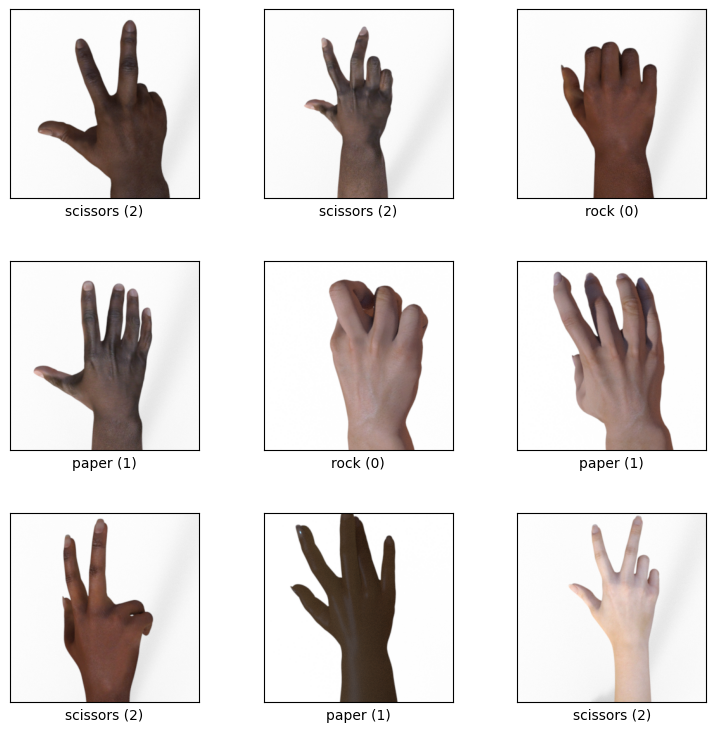

In [ ]:
# TODO: Visualize examples
vis = tfds.visualization.show_examples(raw_train, metadata)



We reshape the images to (224, 224, 3) and split the dataset into batches to reduce memory requirement.

In [ ]:
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label

BATCH_SIZE = 32
train_batches = raw_train.shuffle(metadata.splits['train'].num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

### Define pre-trained model

Similar to what we did in Tutorial 2.2, we will use Transfer Learning to train our model. We will use the weights of a MobileNet model pre-trained on the ImageNet Dataset.

In [ ]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))


Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


### Define your model

In the below cell, define your model. Use the feature extractor of the pre-trained mobilenet model as the initial layers. To complete your model, add layers to match the desired number of output classes.

Choose an appropriate Optimizer and Loss Function and compile your model.

In [ ]:
# TODO: Define and Compile model
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   output_shape=[FV_SIZE],
                                   trainable=False)

print("Building model with", MODULE_HANDLE)



# model layers stacked
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])
# compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4


### Summarize your model



In [ ]:
# TODO: Summarize your model
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


---


**Question 2**: Can you explain how we arrive at the number of parameters observed in the output layer of your above model?

**Answer:**

The output layer of the model you have provided is a dense (fully connected) layer, and it has 3,843 parameters. We come to this number as follows:

Number of Parameters=(Number of Input Nodes×Number of Output Nodes)+Number of Output Nodes

where the first term corresponds to the weight term and the second one corresponds to the bias term.

The calculation yields a total of 3843 parameters in the dense layer, which matches the model summary provided.

1280×3=3840 parameters are weights, coming from each input node connecting to each output node.
An additional 3 parameters are biases, one for each output node.
Hence, in total, we have 3843 parameters in the dense layer.

### Train your model

In the below cell, train your model! You can choose an arbitrary number of epochs.

In [ ]:
# TODO: Train your model
history = model.fit(
    train_batches,  # training data
    epochs=10,  # number of epochs
    validation_data=validation_batches  # validation data
)

# Maybe I should've stopped at Epoch 4, didn't want to rerun everything, so kept it this way

Epoch 1/10
63/63 [==============================] - 19s 96ms/step - loss: 0.3884 - accuracy: 0.8814 - val_loss: 0.1236 - val_accuracy: 0.9821
Epoch 2/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0833 - accuracy: 0.9931 - val_loss: 0.0586 - val_accuracy: 0.9980
Epoch 3/10
63/63 [==============================] - 3s 43ms/step - loss: 0.0443 - accuracy: 0.9995 - val_loss: 0.0366 - val_accuracy: 1.0000
Epoch 4/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.0254 - val_accuracy: 1.0000
Epoch 5/10
63/63 [==============================] - 4s 65ms/step - loss: 0.0207 - accuracy: 1.0000 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 6/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 7/10
63/63 [==============================] - 3s 43ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 8/10
6

### Plot Accuracy and Loss Graph

In the below cell, plot two graphs. **Plot 1** should contain both training and validation accuracies vs Epochs. **Plot 2** should contain both training and validation losses vs Epochs. Be sure to include a legend, title, and x & y axis labels.

***Hint:*** Use plt.subplots()

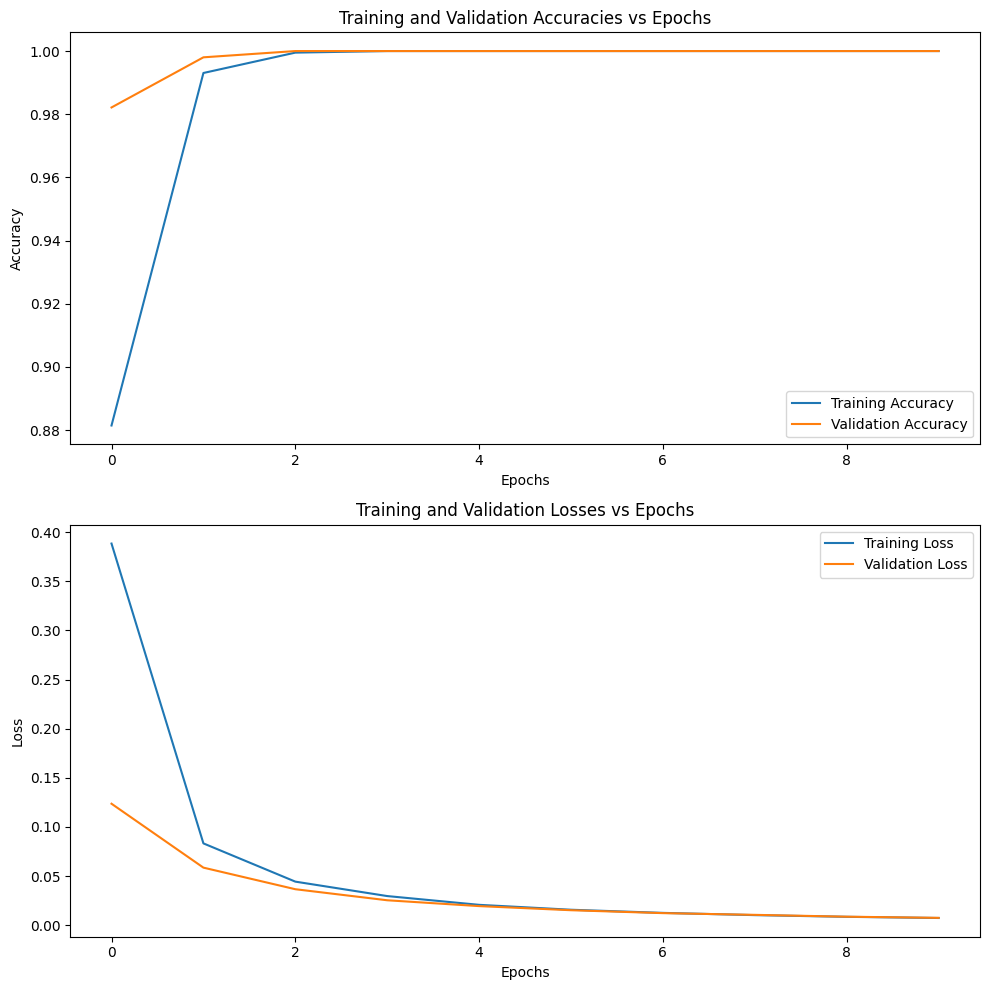

In [ ]:
# TODO: Plot accuracy and loss graphs for both the train and validation data sets.

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot 1: Training and Validation Accuracies vs Epochs
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracies vs Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')

# Plot 2: Training and Validation Losses vs Epochs
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Training and Validation Losses vs Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()


### Save the Baseline model

We save the trained baseline model!

In [ ]:
ROCK_PAPER_SCISSORS_SAVED_MODEL = "saved_model"
tf.saved_model.save(model, ROCK_PAPER_SCISSORS_SAVED_MODEL)

### Model 1: Create a TensorFlow Lite model.

In the below cell, convert your Baseline TensorFlow model to a TensorFlow Lite model. **Save this model as 'model1.tflite'!**

***Hint:*** You'll need to use the saved model to generate a converter.

In [ ]:
# Convert to TFLite model
converter = tf.lite.TFLiteConverter.from_saved_model(ROCK_PAPER_SCISSORS_SAVED_MODEL) #<YOUR CODE HERE>
tflite_model = converter.convert()


tflite_models_dir = pathlib.Path("/content/")
tflite_model_file = tflite_models_dir/'model1.tflite'
print("Size of model1:", tflite_model_file.write_bytes(tflite_model))



Size of model1: 8880424


### Model 2: Create a TensorFlow Lite model with Float-16 Quantization.

In the below cell, create a TensorFlow Lite model where the weights are converted from 'Float32' to 'Float16' values. **Save this model as 'model2.tflite'!**

In [ ]:
# Convert to TFLite model with Float-16 Quantization

# Initialize the TFLiteConverter with your model
converter = tf.lite.TFLiteConverter.from_saved_model(ROCK_PAPER_SCISSORS_SAVED_MODEL)

# Specify the optimization to use default optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Specify the target specification to use Float16 quantization
converter.target_spec.supported_types = [tf.float16]

# Convert the model to tflite format
tflite_model = converter.convert()

# Save the converted model to 'model2.tflite'
with open('model2.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model has been converted and saved as 'model2.tflite'")
print("Size of model2:", tflite_model_file.write_bytes(tflite_model))



Model has been converted and saved as 'model2.tflite'
Size of model2: 4477892


---


**Question 3**: What do you observe about the size of model2 w.r.t model1?

**Answer:** It is half the size of model 1. This makes sense since we are converting the model from 32-bytes down to 16-bytes. It will help with the storage, memory and hopefully the performance.

---

### Evaluation

In this section, we will evaluate both our TFLite models. What's the best way to run inference on Colab? Code it up in the cell below.

Predict the 'class label' for 100 test images. Report (a) the number of iterations/second and (b) the number of correct predictions for both model1.tflite and model2.tflite!

In [ ]:
# TODO: Run inference on both TFLite models

def evaluate_model(tflite_model_file, test_batches, num_samples=100):
    # Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    predictions = []
    test_labels = []
    for img, label in tqdm(test_batches.take(num_samples), desc=f"Evaluating {tflite_model_file}"):
        interpreter.set_tensor(input_index, img)
        interpreter.invoke()
        predictions.append(interpreter.get_tensor(output_index))
        test_labels.append(label.numpy()[0])

    score = sum(np.argmax(predictions[i]) == test_labels[i] for i in range(num_samples))
    print(f"{tflite_model_file}: Out of {num_samples} predictions, got {score} correct")
    return score

# Evaluate the first model
tflite_model_file1 = 'model1.tflite'
score1 = evaluate_model(tflite_model_file1, test_batches)

# Evaluate the second model
tflite_model_file2 = 'model2.tflite'
score2 = evaluate_model(tflite_model_file2, test_batches)

Evaluating model1.tflite: 100%|██████████| 100/100 [00:01<00:00, 51.36it/s]


model1.tflite: Out of 100 predictions, got 88 correct


Evaluating model2.tflite: 100%|██████████| 100/100 [00:01<00:00, 68.33it/s]

model2.tflite: Out of 100 predictions, got 88 correct


## Plot Results

In this section, you can explore the results of both the models! It can help you visualize the images that the model predicts correct/incorrect.


In [ ]:
# Utilities for plotting

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

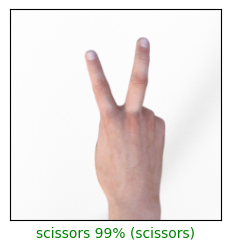

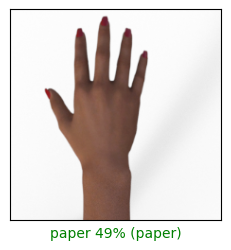

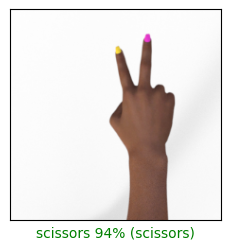

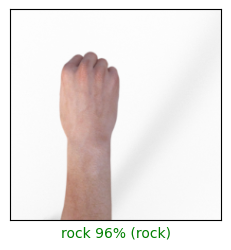

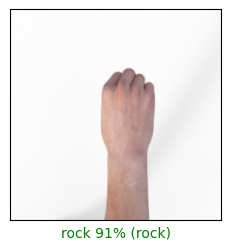

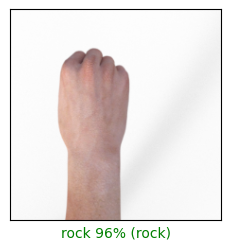

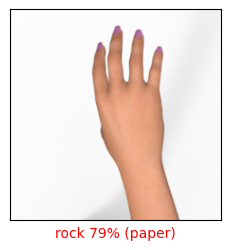

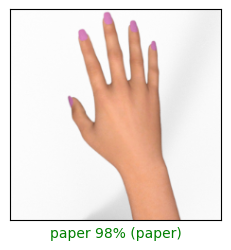

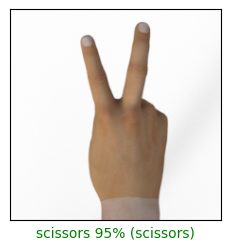

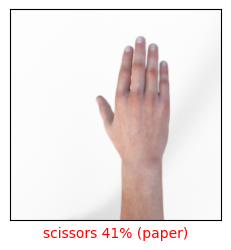

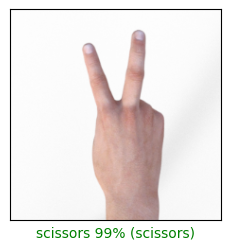

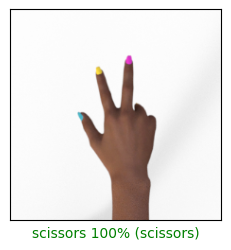

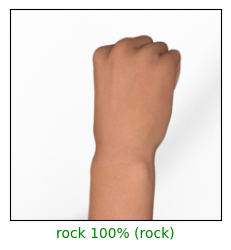

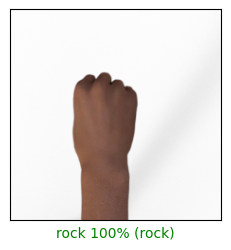

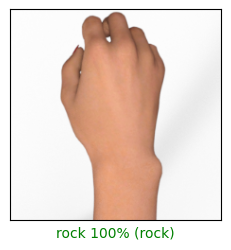

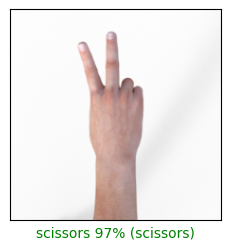

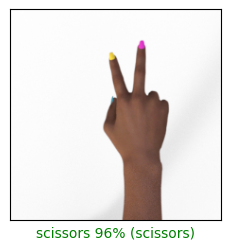

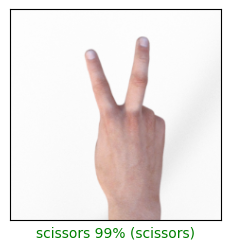

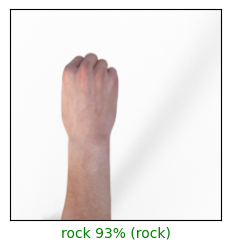

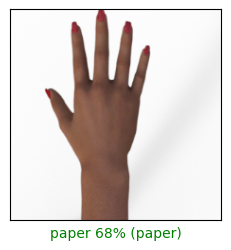

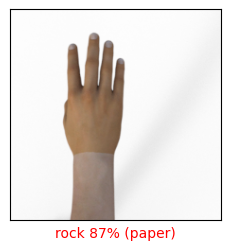

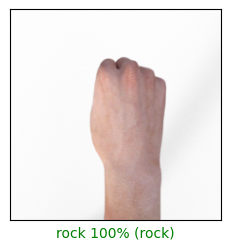

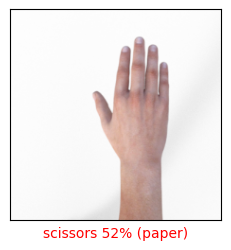

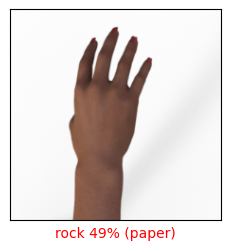

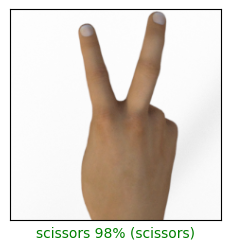

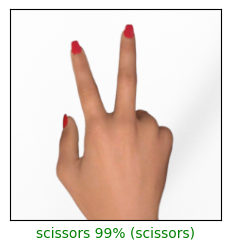

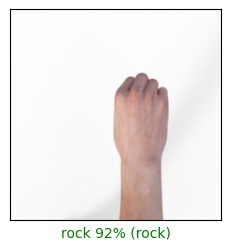

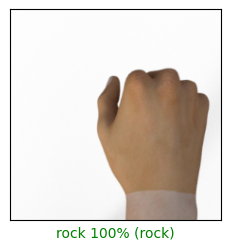

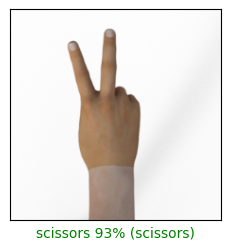

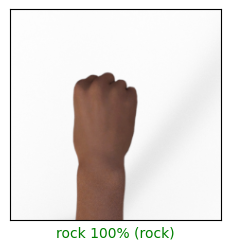

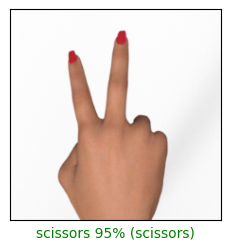

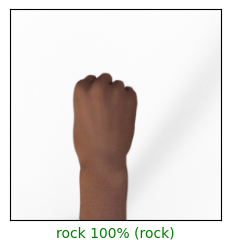

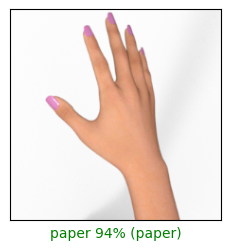

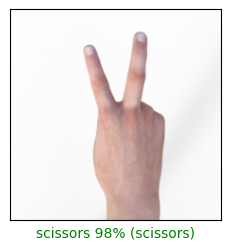

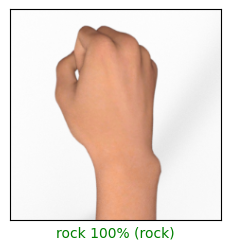

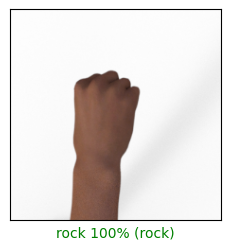

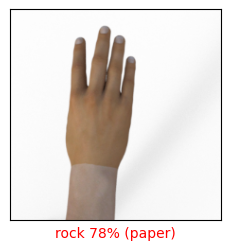

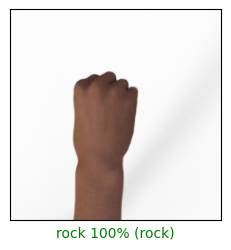

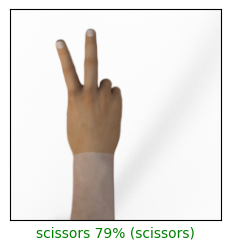

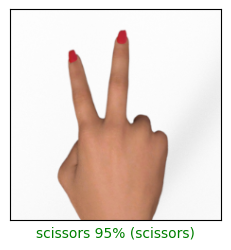

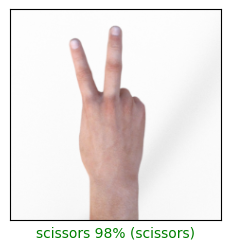

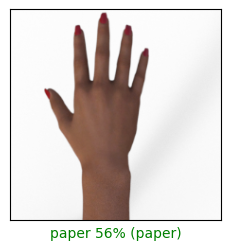

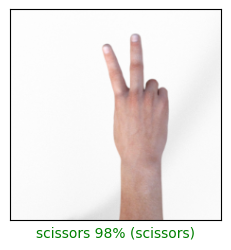

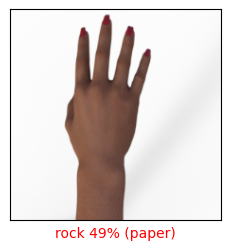

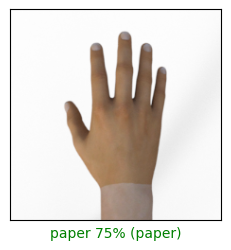

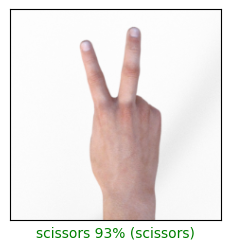

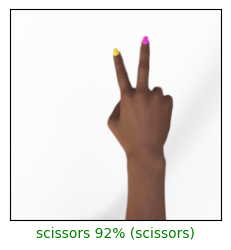

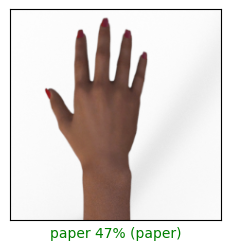

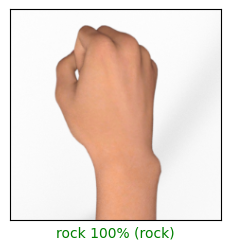

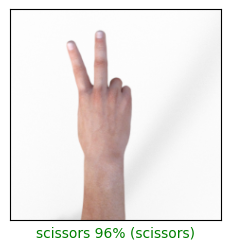

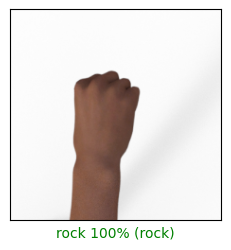

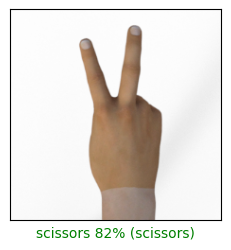

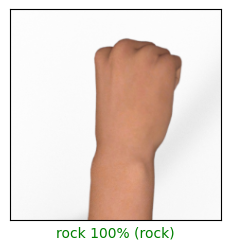

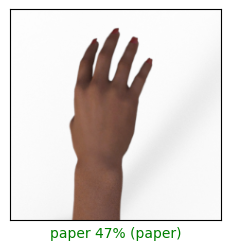

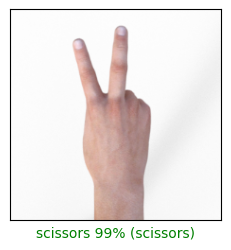

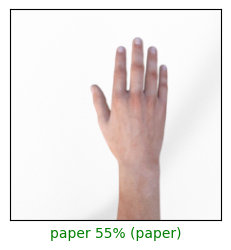

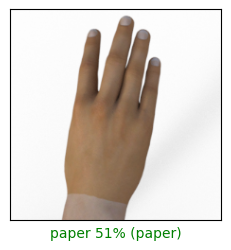

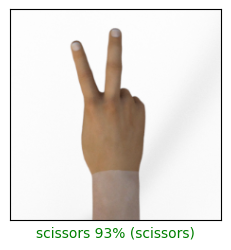

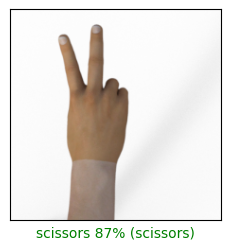

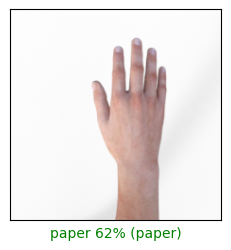

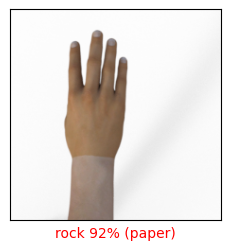

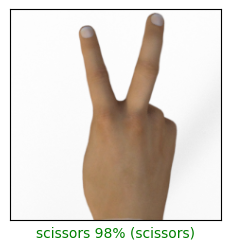

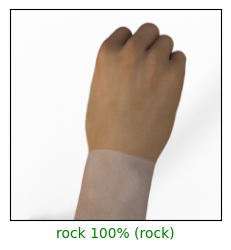

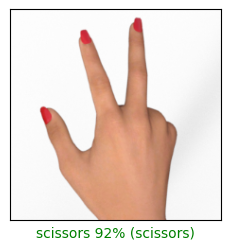

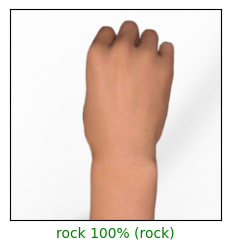

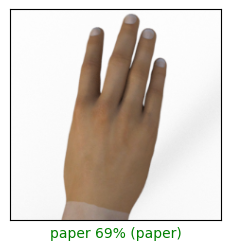

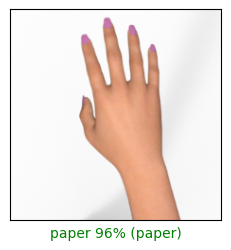

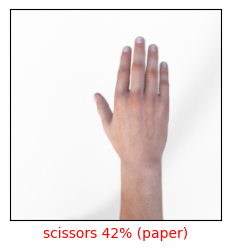

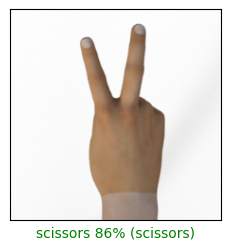

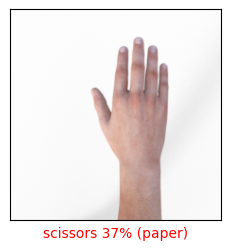

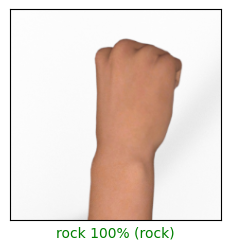

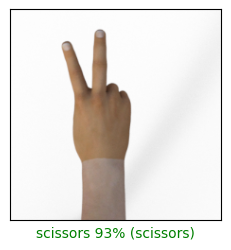

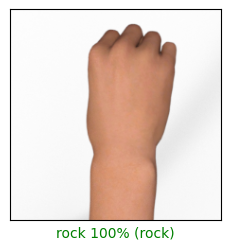

In [ ]:
#@title Visualize the outputs { run: "auto" }
max_index = 73 #@param {type:"slider", min:0, max:99, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()



---



### **Additional Note**
Experiment with your model (no. of layers, optimizer, batch size etc.) and see if you can increase the number of correct predictions! **This is not graded!**